In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import gzip
import pickle
 

In [3]:
# Function to load data from a .gz file
def load_from_gz(filename):
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the data
loaded_images = load_from_gz('colored_mnist_images.gz')
loaded_targets = load_from_gz('colored_mnist_targets.gz')


In [4]:

class ColoredMNISTDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        return torch.tensor(image), target

# Create the dataset
train_dataset = ColoredMNISTDataset(loaded_images, loaded_targets)

# Create a DataLoader for the dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


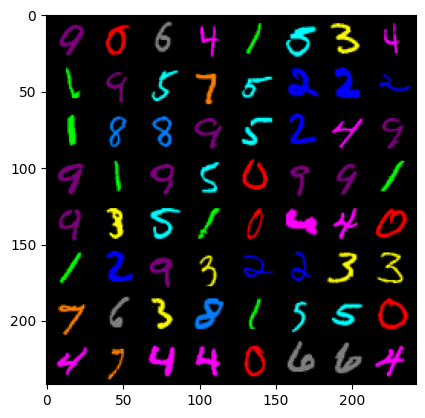

    9     0     6     4     1     5     3     4


In [5]:
# Function to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))


In [30]:
class ColoredNet(nn.Module):
    def __init__(self):
        super(ColoredNet, self).__init__()
        self.fc1 = nn.Linear(3 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.flat(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return x

net = ColoredNet()

img=train_dataset[0][0]
img=img.unsqueeze(0)
summary(net, input_size = img.size())

Layer (type:depth-idx)                   Output Shape              Param #
ColoredNet                               [1, 10]                   --
├─Flatten: 1-1                           [1, 2352]                 --
├─Linear: 1-2                            [1, 128]                  301,184
├─ReLU: 1-3                              [1, 128]                  --
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 10]                   1,290
├─ReLU: 1-6                              [1, 10]                   --
Total params: 302,474
Trainable params: 302,474
Non-trainable params: 0
Total mult-adds (M): 0.30
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.21
Estimated Total Size (MB): 1.22

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [34]:
num_epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net=net.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in tqdm(train_dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}")



100%|██████████| 938/938 [00:05<00:00, 161.71it/s]


Epoch 1, Loss: 0.23440917953153823


100%|██████████| 938/938 [00:06<00:00, 135.47it/s]


Epoch 2, Loss: 0.23260580679612247


100%|██████████| 938/938 [00:06<00:00, 150.52it/s]

Epoch 3, Loss: 0.2321308566035309


In [35]:

loaded_test_images = load_from_gz('colored_mnist_test_images.gz')


class TestMNISTDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        return torch.tensor(image)

# Create the new dataset
test_dataset = TestMNISTDataset(loaded_test_images)

# Create a DataLoader for the new dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)



In [36]:

predictions=[]

for img in test_dataloader :
    img = img.to(device)
    l=np.array(net(img.float()).tolist())
    predicted=[]
    for i in range(len(l)) :
        predicted.append(np.argmax(l[i]))
    predictions.extend(predicted)


np.save('predictions.npy', predictions)